In [ ]:
%pip install -Uq upgini catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.1 MB/s eta 0:00:00


In [ ]:
# Preparing input Data

In [ ]:
from os.path import exists
import pandas as pd

# It helps to check wether the file is downloaded or not. It is beneficial while re-running the steps.
df_path= 'train.csv.zip' if exists("train.csv.zip") else "https://raw.githubusercontent.com/upgini/upgini/main/notebooks/train.csv.zip"
# Reading csv file.
df= pd.read_csv(df_path)
# Taking sample data.
df= df.sample(n=19_000,random_state=0)
# Converting store and item to string type.
df["store"]= df["store"].astype(str)
df["item"]= df["item"].astype(str)
# Conveting date into date time column,it will make sorting easier.
df["date"]= pd.to_datetime(df["date"])

# Sorting the data values, date wise to get them in chronological order.
df.sort_values("date", inplace=True)  #inplace=True keyword in a pandas is a                         v
                                      #method changes the default behaviour such that the operation  v
                                      #on the dataframe doesn't return anything, it instead          v
                                      #'modifies the underlying data' (more on that later).          v
                                      #It mutates the actual object which you apply it to."""        v

df.reset_index(inplace=True,drop=True) # Drop creates a new dataframe leaving original one unchanged.
df.head() # To get top 5 rows of the data set.

,date,store,item,sales
0,2013-01-01,7,5,5
1,2013-01-01,4,9,19
2,2013-01-01,1,33,37
3,2013-01-01,3,41,14
4,2013-01-01,5,24,26


In [ ]:
# Splitting the data into training and testing datasets.
train = df[df["date"]<"2017-01-01"] # It means that data before January 2017  v
                                    # put it into the training dataset.

test = df[df["date"]>="2017-01-01"] # It means that data from January 2017    v
                                    # put it into the testing dataset.


In [ ]:
# Spliting the data into features and labels.
# Features:- These are input values.
# Labels:- These are what we want predict.
train_features = train.drop(columns=["sales"]) # Every column is present in   v
                                    #training feature here expect for sales.

#(Since we are going to be predicting sales, so it would be in train_target).
train_target = train["sales"] # We are going to predict sales.

test_features = test.drop(columns=["sales"]) # Every column is present in   v
                                    #testing feature here expect for sales.

#Since we are going to be predicting sales, so it would be in test_target).
test_target = test["sales"]

In [ ]:
# Enriching Features

In [ ]:
from upgini import FeaturesEnricher, SearchKey
from upgini.metadata import CVType
# Creating a brand feature enricher giving it search keys of date becuase we  v
# need date referring to the same date type.                                  v
# Whatever new data the upgini is giving to us would be referring to the same v
# date type that would be according our dataset date that is between          v
# 2013 - 2017 because we want data specific to this time. So date is used as  v
# search key in this instance and CVType.timeseries is used to indicate the   v
# that it is a time series dataset.
enricher = FeaturesEnricher(
    search_keys= {
        "date": SearchKey.DATE,
    },
    cv= CVType.time_series
)

# Fitting enricher to training dataset.
enricher.fit(train_features, train_target,
             eval_set=[(test_features, test_target)])

<IPython.core.display.Javascript object>

Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history
Detected task type: ModelTaskType.REGRESSION



Column name,Status,Errors
date,All valid,-
target,All valid,-



Running search request, search_id=742d958c-6f48-4f20-b9f5-99da4c758d64
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com


26 relevant feature(s) found with the search keys: ['date']


,,item,0.604418,100.000000,categorical,
,,store,0.203187,100.000000,categorical,
Upgini,Public data,f_weather_date_weather_umap_48_b39cd0c4,0.037925,100.000000,numerical,Free
Upgini,Public data,f_events_date_week_sin1_847b5db1,0.032402,100.000000,numerical,Free
Upgini,Public data,f_events_date_year_cos1_9014a856,0.031167,100.000000,numerical,Free
Upgini,Public data,f_weather_date_weather_umap_31_fa6d9a99,0.028603,100.000000,numerical,Free
Upgini,Public data,f_weather_date_weather_pca_0_d7e0a1fc,0.018406,100.000000,numerical,Free
Upgini,Public data,f_events_date_week_cos3_7525fe31,0.009401,100.000000,numerical,Free
Upgini,Public data,f_weather_date_weather_umap_47_5123ef0a,0.004084,100.000000,numerical,Free
Upgini,Public data,f_weather_date_weather_umap_34_c3ef5b4f,0.003799,100.000000,numerical,Free
Upgini,Public data,f_weather_date_weather_umap_33_89bb7578,0.002716,100.000000,numerical,Free


Calculating accuracy uplift after enrichment...

Quality metrics


,Rows,Baseline mean_squared_error,Enriched mean_squared_error,Uplift
,,,,
Train,15213,331.590507,196.536859,135.053649
Eval 1,3787,581.575525,392.764613,188.810912


In [ ]:
# SHAP Value:- It is a mathematical value that indicates that how relevant     v
#              or influential the feature is towards the prediction.

In [ ]:
# Definfing CATBOOST Model
from catboost import CatBoostRegressor
from catboost.utils import eval_metric

model = CatBoostRegressor(verbose=False, allow_writing_files=False,
                          random_state=0)
# Calculating Metrics
enricher.calculate_metrics(
    train_features, train_target,
    eval_set = [(test_features, test_target)],
    estimator = model,
    scoring = "mean_absolute_percentage_error"
) # Scoring is for checking how accurate the model is,
  # so we are using mean absolute percentage error.

Calculating accuracy uplift after enrichment...


,Rows,Baseline mean_absolute_percentage_error,Enriched mean_absolute_percentage_error,Uplift
,,,,
Train,15213,0.256710,0.156822,0.099888
Eval 1,3787,0.273117,0.184620,0.088497


In [ ]:
# Adding all the new features in the existing dataset.
enriched_train_features = enricher.transform(train_features, keep_input=True)
# By using transform feature from the upgini library, we feed our existing     v
# training dataset and then we get a brand new enriched train feature dataset  v
# which includes all the new features upgini has created.                      v
# And, (keep_input = True) so that are existing initial columns are remaining  v
# there and repeat this for test dataset as well.
enriched_test_features = enricher.transform(test_features, keep_input=True)
enriched_train_features.head()

Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history


Column name,Status,Errors
date,All valid,-



Running search request, search_id=87714586-10d0-4193-8b1d-49c1cf6ccaec
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...
Try to add other keys like the COUNTRY, POSTAL_CODE, PHONE NUMBER, EMAIL/HEM, IPv4 to your training dataset
for search through all the available data sources.
See docs https://github.com/upgini/upgini#-total-239-countries-and-up-to-41-years-of-history


Column name,Status,Errors
date,All valid,-



Running search request, search_id=0d30334f-a10b-46ab-a23e-3c61425fe376
We'll send email notification once it's completed, just use your personal api_key from profile.upgini.com

Retrieving selected features from data sources...


,date,store,item,f_weather_date_weather_umap_48_b39cd0c4,f_events_date_week_sin1_847b5db1,f_events_date_year_cos1_9014a856,f_weather_date_weather_umap_31_fa6d9a99,f_weather_date_weather_pca_0_d7e0a1fc,f_events_date_week_cos3_7525fe31,f_weather_date_weather_umap_47_5123ef0a,...,f_economic_date_cbpol_pca_2_33d6e3fc,f_weather_date_weather_umap_13_842ae1fc,f_financial_date_silver_14e835ea,f_economic_date_cpi_umap_7_d43e2396,f_events_date_italy_game_cnt_99570b80,f_economic_date_cbpol_umap_1_7eb7a343,f_events_date_year_sin3_e4c1ec0e,f_weather_date_weather_pca_3_006924ed,f_financial_date_finance_umap_0_526a7a88,f_weather_date_weather_umap_11_c0a11c2b
0,2013-01-01,7,5,4.540985,0.781831,0.98522,4.712653,29.676683,-0.900969,5.927147,...,-0.902496,3.775319,30.173,11.154531,0,-2.823207,0.493776,3.784451,11.027318,5.341258
1,2013-01-01,4,9,4.540985,0.781831,0.98522,4.712653,29.676683,-0.900969,5.927147,...,-0.902496,3.775319,30.173,11.154531,0,-2.823207,0.493776,3.784451,11.027318,5.341258
2,2013-01-01,1,33,4.540985,0.781831,0.98522,4.712653,29.676683,-0.900969,5.927147,...,-0.902496,3.775319,30.173,11.154531,0,-2.823207,0.493776,3.784451,11.027318,5.341258
3,2013-01-01,3,41,4.540985,0.781831,0.98522,4.712653,29.676683,-0.900969,5.927147,...,-0.902496,3.775319,30.173,11.154531,0,-2.823207,0.493776,3.784451,11.027318,5.341258
4,2013-01-01,5,24,4.540985,0.781831,0.98522,4.712653,29.676683,-0.900969,5.927147,...,-0.902496,3.775319,30.173,11.154531,0,-2.823207,0.493776,3.784451,11.027318,5.341258


In [ ]:
# At first we will train and evaluate our model on the original dataset and we v
# will do the same with the enriched features dataset and compare them to see  v
# the error rate and to see which one turns out to be better.                  v
# SMAPE(Symmetric Mean Absolute Percentage Error):- It is an accuracy measure  v
# based on percentage(or relative) errors. And we are using SMAPE here to
# see that what are model should actually predicted and what it should be
# actually predicting.

In [ ]:
# Training and testing the original dataset                               v
# (that is without any enriched features.) and checking the accuracy.
model.fit(train_features, train_target)
preds = model.predict(test_features)
print("Error Percentage score of model with the original dataset:")
eval_metric(test_target.values, preds, "SMAPE")

Error Percentage score of model with the original dataset:


[37.65141857448004]

In [ ]:
# Training the model with the enriched features dataset                    v
# and checking the accuracy.
model.fit(enriched_train_features, train_target)
enriched_preds = model.predict(enriched_test_features)
print("Error Percentage score of model with enrcihed features to the original dataset:")
eval_metric(test_target.values, enriched_preds, "SMAPE")

Error Percentage score of model with enrcihed features to the original dataset:


[14.368929057949583]

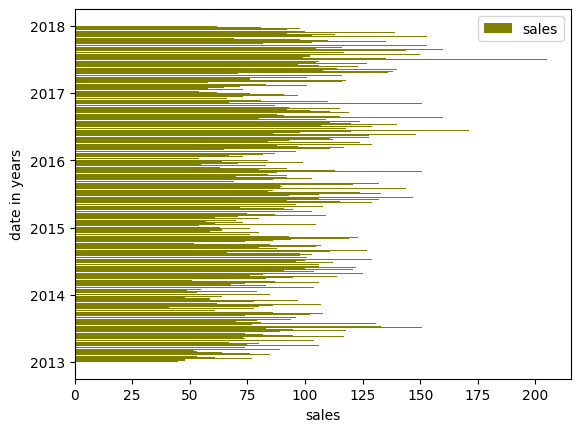

In [ ]:
# Add graph for data vizualization. (without enriched features.)
import matplotlib.pyplot as plt
df1 = pd.to_datetime(df["date"])
df2 = df["sales"]
plt.barh(df1,df2,color='olive',label='sales')
plt.xlabel('sales')
plt.ylabel('date in years')
plt.legend()
plt.show()